In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import colors as mcolors 
from matplotlib_venn import venn2
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

### Keyword list with unique identifiers per publication on Scopus AI

In [2]:
ScopusAIphys = pd.read_csv('./../Data/Curated_Dataset/Raw_AI_Join_on_Query_Terms_Technical_Physical_Science_1997_2018_20191104.csv')
ScopusAIsoc = pd.read_csv('./../Data/Curated_Dataset/Raw_AI_Join_on_Query_Terms_Social_Science_1997_2018_20191104.csv')

In [3]:
UniquePhys = pd.unique(ScopusAIphys['EID'])
AllPhys = ScopusAIphys
len(UniquePhys), AllPhys.shape[0]

(498407, 671335)

In [4]:
UniqueSoc = pd.unique(ScopusAIsoc['EID'])
AllSoc = ScopusAIsoc
len(UniqueSoc), AllSoc.shape[0]

(107807, 127430)

In [5]:
ScopusAI = pd.concat([ScopusAIphys, ScopusAIsoc])
AllKeys = ScopusAI['Keyword'].unique()
UniqueAll = pd.unique(ScopusAI['EID'])
Intersection = set(ScopusAIphys['EID']).intersection( set( ScopusAIsoc['EID'] ) )
len(UniqueAll)

544067

### Overlaps of keywords across clusters are left out in the physical domain. In the social there is no such issue
#### Left out: 1. machine learning, 2. autonomous vehicles, 3. generative adversarial networks, 4. geospatial intelligence, 5. geographic information system, 6. remote sensing, 7. computational linguistics, 8. bioinformatics
### Social keywords left out due to their high reference scores in the physical domain
#### 1. policy, 2. law, 3. "decision making" ("deep fake" missing from the returned results)

In [6]:
# 12 ELSI, 4 F&E, 9 R&G, 5 R&D
# 9 SL, 2 UL, 2 RL

# ML index in AllKeys: 1
# Robo index in AllKeys: 8
# AVs index in AllKeys: 17
# BC&DL index in AllKeys: 23, 24

KeysToPhysMainKeys = { 'ML' : [ AllKeys[0] ], 'Rob' : [ AllKeys[8] ], 'AVs' : [ AllKeys[17] ], 
                      'BC&DL' : [ AllKeys[23], AllKeys[24] ] }

KeysToSocClust = {'ELSI' : [ AllKeys[31], AllKeys[32], AllKeys[39], AllKeys[40], AllKeys[41], 
                         AllKeys[42], AllKeys[46], AllKeys[47], AllKeys[49], AllKeys[50], 
                         AllKeys[52], AllKeys[57] ], 
               'F&E' : [ AllKeys[30], AllKeys[36], AllKeys[51], AllKeys[61] ], 
               'R&G' : [ AllKeys[37], AllKeys[44], AllKeys[45], AllKeys[53], 
                    AllKeys[54], AllKeys[55], AllKeys[58], AllKeys[60], AllKeys[48] ], 
               'R&D' : [ AllKeys[34], AllKeys[38], AllKeys[43], AllKeys[56], AllKeys[59]] } 

KeysToPhysClust = {'SL' : [ AllKeys[1], AllKeys[3], AllKeys[4], AllKeys[6], AllKeys[7], AllKeys[12], AllKeys[19], 
                      AllKeys[20], AllKeys[27] ], 
               'UL' : [ AllKeys[2], AllKeys[13] ], 
               'RL' : [ AllKeys[8], AllKeys[16] ]}

KeysToClust = {'ELSI' : [ AllKeys[31], AllKeys[32], AllKeys[39], AllKeys[40], AllKeys[41], 
                         AllKeys[42], AllKeys[46], AllKeys[47], AllKeys[49], AllKeys[50], 
                         AllKeys[52], AllKeys[57] ], 
               'F&E' : [ AllKeys[30], AllKeys[36], AllKeys[51], AllKeys[61] ], 
               'R&G' : [ AllKeys[37], AllKeys[44], AllKeys[45], AllKeys[53], 
                    AllKeys[54], AllKeys[55], AllKeys[58], AllKeys[60], AllKeys[48] ], 
               'R&D' : [ AllKeys[34], AllKeys[38], AllKeys[43], AllKeys[56], AllKeys[59]], 
                'SL' : [ AllKeys[1], AllKeys[3], AllKeys[4], AllKeys[6], AllKeys[7], AllKeys[12], AllKeys[19], 
                      AllKeys[20], AllKeys[27] ], 
               'UL' : [ AllKeys[2], AllKeys[13] ], 
               'RL' : [ AllKeys[8], AllKeys[16] ]}

In [7]:
Soc = []
Phys = []
for  sublist in list(KeysToSocClust.values()):
    for j in sublist:
        Soc.append(j)
        
for  sublist in list(KeysToPhysClust.values()):
    for j in sublist:
        Phys.append(j)

In [8]:
UsedKwds = []
for sublist in KeysToClust.values():
    for j in sublist:
        UsedKwds.append(j)
UsedClust = list(KeysToClust.keys())

### Keep just the keywords used in the clusters as the AI event space for the analysis (up to an including 2018)

In [9]:
ScopusAI = ScopusAI[(ScopusAI['Keyword'].isin(UsedKwds)) & (ScopusAI['sort_year'] != 2019)]
ScopusAIphys = ScopusAIphys[(ScopusAIphys['Keyword'].isin(UsedKwds)) & (ScopusAIphys['sort_year'] != 2019)]
ScopusAIsoc = ScopusAIsoc[(ScopusAIsoc['Keyword'].isin(UsedKwds)) & (ScopusAIsoc['sort_year'] != 2019)]
UniqueAll = pd.unique(ScopusAI['EID'])
Intersection = set(ScopusAIphys['EID']).intersection( set( ScopusAIsoc['EID'] ) )
len(UniqueAll)

458239

In [10]:
# Mutually exclusive physical and social publications
len(UniqueAll)-len(Intersection)

425214

In [11]:
# Mutually exclusive sets of physical and social publications separately and concatenated overall AI domain
ScopusAIphysMEIDs = set(pd.unique(ScopusAIphys['EID'])).difference( pd.unique(ScopusAIsoc['EID']) )
ScopusAIsocMEIDs = set( pd.unique(ScopusAIsoc['EID']) ).difference( pd.unique(ScopusAIphys['EID']) )
ScopusAIMEIDs = list(ScopusAIphysMEIDs) + list(ScopusAIsocMEIDs)

In [12]:
len(ScopusAIphysMEIDs)/len(UniqueAll), len(ScopusAIsocMEIDs)/len(UniqueAll), len(Intersection)/len(UniqueAll)

(0.8456067685203573, 0.08232385283662019, 0.07206937864302253)

In [13]:
len(Intersection)

33025

Text(0.5, 1.0, 'Curated Scopus AI Set of 458,239 unique publications')

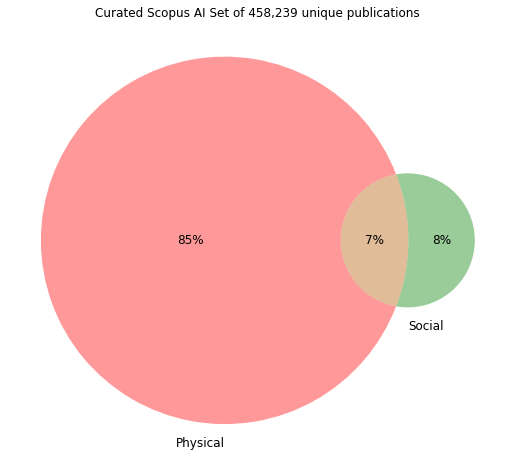

In [14]:
plt.figure(figsize=(12,8))
Sets = [len(UniquePhys), len(ScopusAIsocMEIDs), len(Intersection)]
Labels = ('Physical', 'Social')
InnerLabels = ['85%' , '8%', '7%']
out = venn2(Sets, Labels)
for text in out.set_labels:
    text.set_fontsize(12)
for text,subtext in zip(out.subset_labels,InnerLabels):
    text.set_fontsize(12)
    text.set_text(subtext)
plt.title('Curated Scopus AI Set of 458,239 unique publications', fontsize=12)
# plt.savefig('./../Manuscripts/Images/Phys_Soc_overlap.png', dpi=150)

In [15]:
ScopusAIME = ScopusAI[ScopusAI['EID'].isin(ScopusAIMEIDs)]
ScopusAIIntersection = ScopusAI[ScopusAI['EID'].isin(Intersection)]

### Explore the overlap of the retained keywords with the Jaccard index per year

In [16]:
KwdsYears = ScopusAIME.groupby(['Keyword', 'sort_year']).count().reset_index()
CompT = {}
for i in range(1997,2019):
    CompT[i] = set(KwdsYears[KwdsYears['sort_year'] == i]['Keyword'])

In [17]:
# Scan through all the years' keyword sets, evaluate their intersections and unions, and ultimately compute the 
# Jaccard index for pairs of years. TODO: Since the Jaccard index is commutative in respect to its pair of 
# sets you can make the below code more efficient by restricting computations to either the upper or lower 
# triangular version of the similarity matrix (in other words, the matrix is symmetric).
IntersectionsT = {}
UnionsT = {}
JaccardT = []

k = 0

for i in range(1997,2019):
    Jacc = []
    for j in range(1997,2019):
#         if i == j:
#             continue
#         else:
        IntersectionsT[str(i) + '_' + str(j)] = CompT[i].intersection(CompT[j])
        UnionsT[str(i) + '_' + str(j)] = CompT[i].union(CompT[j])
        if len(UnionsT[str(i) + '_' + str(j)]) != 0:
            Jacc.append(len(IntersectionsT[str(i) + '_' + str(j)])/len(UnionsT[str(i) + '_' + str(j)]))
        else:
            Jacc.append(float('nan'))
    JaccardT.append(Jacc)
SimMatrixT = pd.DataFrame(JaccardT, index=range(1997,2019), columns=range(1997,2019))
maskT = np.tril(np.ones_like(SimMatrixT.values, dtype=np.bool))

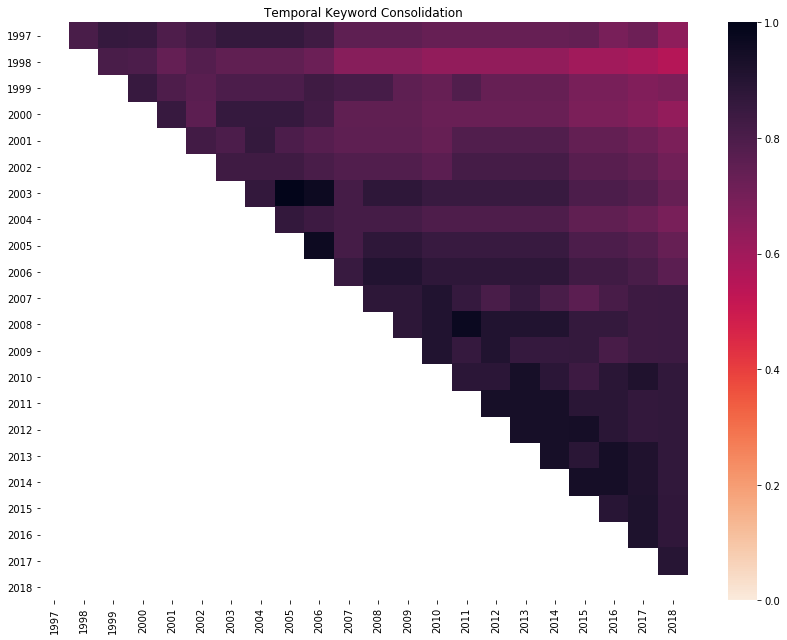

In [18]:
plt.figure(figsize=(12,9))
cmap = sns.cm.rocket_r
ax = sns.heatmap(SimMatrixT, mask=maskT, xticklabels=SimMatrixT.columns.values, cmap=cmap,
            yticklabels=SimMatrixT.columns.values, annot = False, annot_kws={'size' : 12}, vmin=0, 
                vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Temporal Keyword Consolidation', fontsize=12)
plt.tight_layout()

# plt.savefig('./../Manuscripts/Images/JaccT_sim_matrix', dpi=150)

### Explore the overlap of the retained keywords' clusters with the Jaccard index per year

In [19]:
WordsToClust = {}
for i in KeysToClust:
    for j in KeysToClust[i]:
        WordsToClust.update({j : i})

In [20]:
ScopusAIClust = ScopusAIME.replace(WordsToClust)
ClustYears = ScopusAIClust.groupby(['Keyword', 'sort_year']).count().reset_index()
CompTClust = {}
for i in range(1997,2019):
    CompTClust[i] = set(ClustYears[ClustYears['sort_year'] == i]['Keyword'])

In [21]:
# Scan through all the years' keyword sets, evaluate their intersections and unions, and ultimately compute the 
# Jaccard index for pairs of years. TODO: Since the Jaccard index is commutative in respect to its pair of 
# sets you can make the below code more efficient by restricting computations to either the upper or lower 
# triangular version of the similarity matrix (in other words, the matrix is symmetric).
IntersectionsTClust = {}
UnionsTClust = {}
JaccardTClust = []

k = 0

for i in range(1997,2019):
    Jacc = []
    for j in range(1997,2019):
#         if i == j:
#             continue
#         else:
        IntersectionsTClust[str(i) + '_' + str(j)] = CompTClust[i].intersection(CompTClust[j])
        UnionsTClust[str(i) + '_' + str(j)] = CompTClust[i].union(CompTClust[j])
        if len(UnionsTClust[str(i) + '_' + str(j)]) != 0:
            Jacc.append(len(IntersectionsTClust[str(i) + '_' + str(j)])/len(UnionsTClust[str(i) + '_' + str(j)]))
        else:
            Jacc.append(float('nan'))
    JaccardTClust.append(Jacc)
SimMatrixTClust = pd.DataFrame(JaccardTClust, index=range(1997,2019), columns=range(1997,2019))
maskTClust = np.tril(np.ones_like(SimMatrixTClust.values, dtype=np.bool))

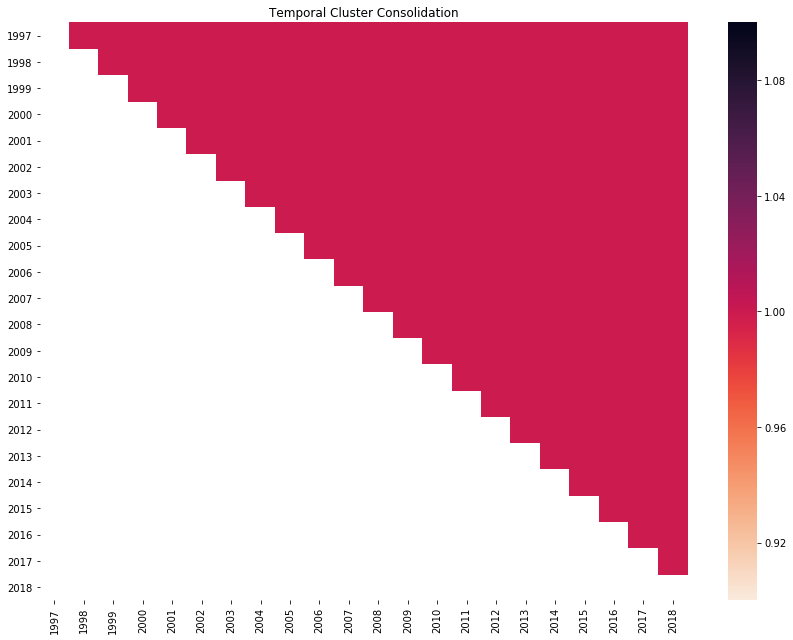

In [22]:
plt.figure(figsize=(12,9))
cmap = sns.cm.rocket_r
ax = sns.heatmap(SimMatrixTClust, mask=maskTClust, xticklabels=SimMatrixTClust.columns.values, cmap=cmap,
            yticklabels=SimMatrixTClust.columns.values, annot = False, annot_kws={'size' : 12} )
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Temporal Cluster Consolidation', fontsize=12)
plt.tight_layout()

# plt.savefig('./../Manuscripts/Images/JaccT_sim_matrix', dpi=150)

### Explore the overlap of the retained keywords' IDs with the Jaccard index

In [23]:
# Gather all the sets of the IDs for all of the dataset's keywords
KwdsIDs = ScopusAIME.groupby(['EID', 'Keyword']).count().reset_index()
Comp = {}
for i in UsedKwds:
    Comp[i] = set(KwdsIDs[KwdsIDs['Keyword'] == i]['EID'])

In [24]:
# Scan through all the keywords' sets, evaluate their intersections and unions, and ultimately compute the 
# Jaccard index. TODO: Since the Jaccard index is commutative in respect to its pair of sets you can make
# the below code more efficient by restricting computations to either the upper or lower triangular version
# of the similarity matrix (in other words, the matrix is symmetric).
Intersections = {}
Unions = {}
Jaccard = []

k = 0

for i in UsedKwds:
    Jacc = []
    for j in UsedKwds:
#         if i == j:
#             continue
#         else:
        Intersections[i + '_' + j] = Comp[i].intersection(Comp[j])
        Unions[i + '_' + j] = Comp[i].union(Comp[j])
        if len(Unions[i + '_' + j]) != 0:
            Jacc.append(len(Intersections[i + '_' + j])/len(Unions[i + '_' + j]))
        else:
            Jacc.append(float('nan'))
    Jaccard.append(Jacc)
SimMatrix = pd.DataFrame(Jaccard, index=UsedKwds, columns=UsedKwds)
mask = np.tril(np.ones_like(SimMatrix.values, dtype=np.bool))

In [25]:
# Collapse all the elements of the similarity matrix in one list and sort it. Then you can inspect it to see 
# the elements of the greatest value close to unity (i.e. avoid the Jaccard index's self-comparisons).
FlatSimMatrix = []
for sublist in SimMatrix.values:
    for j in sublist:
        FlatSimMatrix.append(j)
FlatSimMatrix.sort()

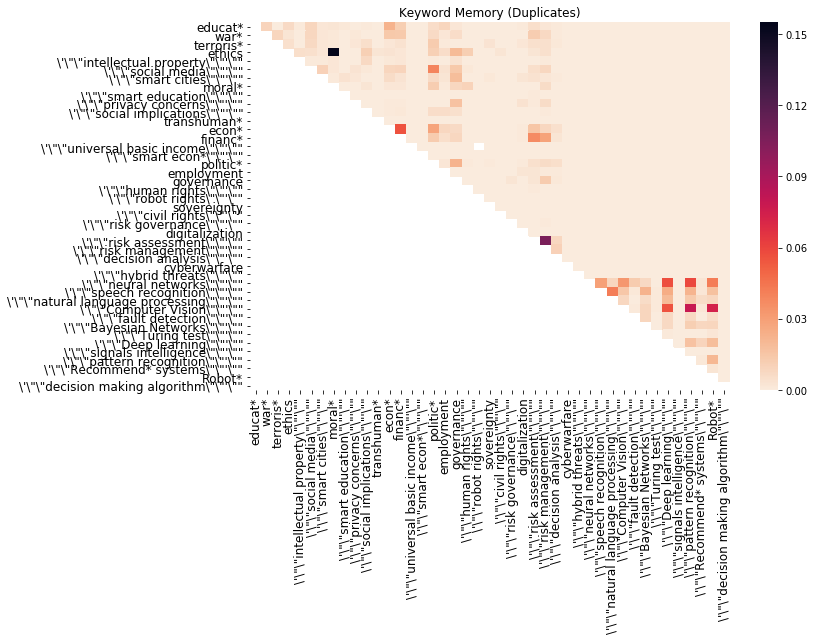

In [26]:
plt.figure(figsize=(12,9))
cmap = sns.cm.rocket_r
ax = sns.heatmap(SimMatrix, mask=mask, xticklabels=SimMatrix.columns.values, cmap=cmap,
            yticklabels=SimMatrix.columns.values, annot = False, annot_kws={'size' : 12}, vmin=0,
                vmax=0.155)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Keyword Memory (Duplicates)', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()

# plt.savefig('./../Manuscripts/Images/Jacc_sim_matrix', dpi=150)

### Explore the overlap of the retained keywords' Clusters IDs with the Jaccard index

In [27]:
# Gather all the sets of the IDs for all of the dataset's keywords
ScopusAIClust = ScopusAIME.replace(WordsToClust)
Clust = ScopusAIClust.groupby(['EID', 'Keyword']).count().reset_index()
Clust = Clust.rename(columns={'Keyword':'Cluster'})
CompClust = {}
for i in UsedClust:
    CompClust[i] = set(Clust[Clust['Cluster'] == i]['EID'])

In [28]:
# Scan through all the keywords' sets, evaluate their IntersectionsClust and UnionsClust, and ultimately compute the 
# JaccardClust index. TODO: Since the JaccardClust index is commutative in respect to its pair of sets you can make
# the below code more efficient by restricting computations to either the upper or lower triangular version
# of the similarity matrix (in other words, the matrix is symmetric).
IntersectionsClust = {}
UnionsClust = {}
JaccardClust = []

k = 0

for i in UsedClust:
    Jacc = []
    for j in UsedClust:
#         if i == j:
#             continue
#         else:
        IntersectionsClust[i + '_' + j] = CompClust[i].intersection(CompClust[j])
        UnionsClust[i + '_' + j] = CompClust[i].union(CompClust[j])
        if len(UnionsClust[i + '_' + j]) != 0:
            Jacc.append(len(IntersectionsClust[i + '_' + j])/len(UnionsClust[i + '_' + j]))
        else:
            Jacc.append(float('nan'))
    JaccardClust.append(Jacc)
SimMatrixClust = pd.DataFrame(JaccardClust, index=UsedClust, columns=UsedClust)
maskClust = np.tril(np.ones_like(SimMatrixClust.values, dtype=np.bool))

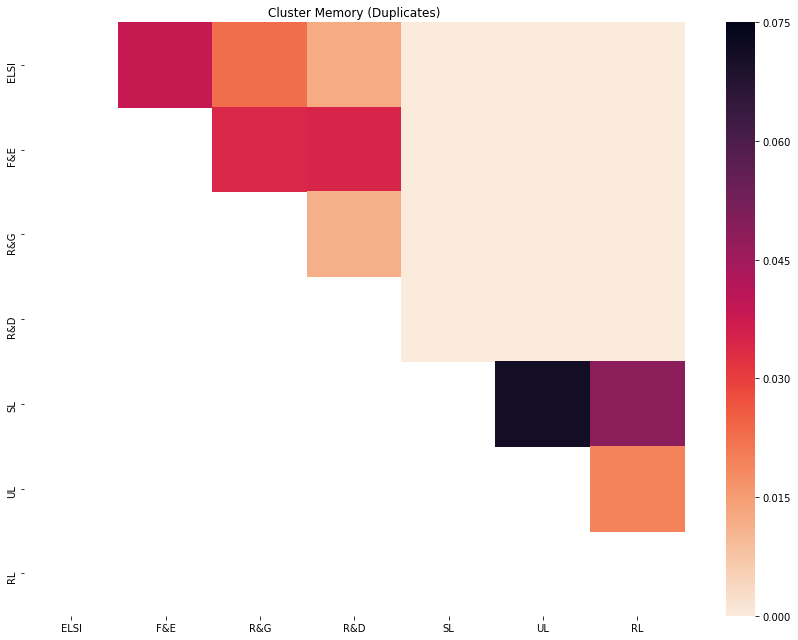

In [29]:
plt.figure(figsize=(12,9))
cmap = sns.cm.rocket_r
ax = sns.heatmap(SimMatrixClust, mask=maskClust, xticklabels=SimMatrixClust.columns.values, cmap=cmap,
            yticklabels=SimMatrixClust.columns.values, annot = False, annot_kws={'size' : 12}, vmin=0,
                vmax=0.075)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Cluster Memory (Duplicates)', fontsize=12)
plt.tight_layout()

# plt.savefig('./../Manuscripts/Images/ClustOverlap', dpi=150)

### Normalized time-series for the 3 physical and 4 social mutually exclusive clusters

In [30]:
PhysYears = []
for i in range(1997,2019):
    ClustYear = []
    for j in KeysToPhysClust:
        temp = 0
        for k in KeysToPhysClust[j]:
            temp += ScopusAIME[(ScopusAIME['Keyword'] == k) & (ScopusAIME['sort_year'] == i)]['Keyword'].count()
        ClustYear.append(temp)
    PhysYears.append(ClustYear)
    
PhysClustSeries = pd.DataFrame(PhysYears,columns=KeysToPhysClust.keys())

SocYears = []
for i in range(1997,2019):
    ClustYear = []
    for j in KeysToSocClust:
        temp = 0
        for k in KeysToSocClust[j]:
            temp += ScopusAIME[(ScopusAIME['Keyword'] == k) & (ScopusAIME['sort_year'] == i)]['Keyword'].count()
        ClustYear.append(temp)
    SocYears.append(ClustYear)
    
SocClustSeries = pd.DataFrame(SocYears,columns=KeysToSocClust.keys())

# Normalize to all the entries per year of the original, concatenated set
TotMESeries = ScopusAI.groupby('sort_year').count().reset_index()['EID']

PhysClustSeriesNorm = PhysClustSeries.T/TotMESeries
SocClustSeriesNorm = SocClustSeries.T/TotMESeries
PhysClustSeriesNorm = PhysClustSeriesNorm.T
SocClustSeriesNorm = SocClustSeriesNorm.T
PhysClustSeriesNorm['Year'] = range(1997,2019)
SocClustSeriesNorm['Year'] = range(1997,2019)

Interlude for the seires of relative gains and losses for each domain

In [194]:
# Calculating the relative gains and losses per year from the normalized series. If longer changes are desired,
# change the period in the diff function and select and then concatenate accordingly.
temp = PhysClustSeriesNorm[PhysClustSeriesNorm.columns[:-1]]
Gden = temp.values[:-1]
ttemp = temp.diff().iloc[1:]
RelGainsPhys = ttemp/Gden

Lden = temp.values[1:]
ttemp = temp.diff(-1).iloc[:-1]
RelLossesPhys = ttemp/Lden

temp = SocClustSeriesNorm[SocClustSeriesNorm.columns[:-1]]
Gden = temp.values[:-1]
ttemp = temp.diff().iloc[1:]
RelGainsSoc = ttemp/Gden

Lden = temp.values[1:]
ttemp = temp.diff(-1).iloc[:-1]
RelLossesSoc = ttemp/Lden

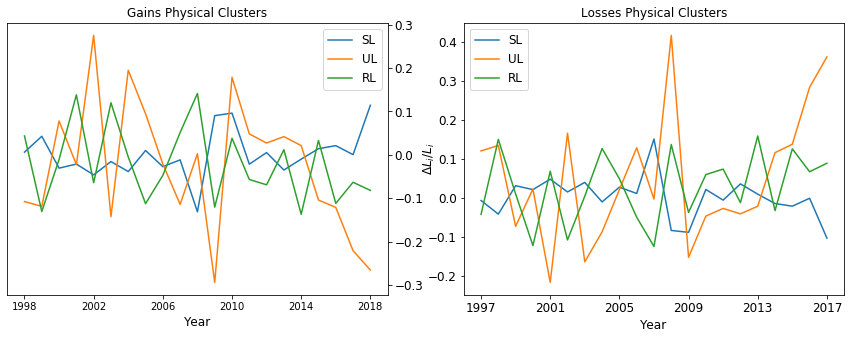

In [195]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(PhysClustSeriesNorm['Year'].iloc[1:], RelGainsPhys)
plt.xlabel('Year', fontsize=12)
plt.ylabel(r'$\Delta L_i/L_i$', fontsize=12, labelpad=-430)
# plt.set_label_position("right")
# plt.yaxis.tick_right()
plt.legend(PhysClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12, axis='y', which='major', labelleft=False, labelright=True, 
                left=False, right=True)
plt.xticks(ticks=[1998, 2002, 2006, 2010, 2014, 2018], labels=[1998, 2002, 2006, 2010, 2014, 2018])
plt.title('Gains Physical Clusters', fontsize=12)

plt.subplot(122)
plt.plot(PhysClustSeriesNorm['Year'].iloc[:-1], RelLossesPhys)
plt.xlabel('Year', fontsize=12)
plt.legend(PhysClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.xticks(ticks=[1997, 2001, 2005, 2009, 2013, 2017], labels=[1997, 2001, 2005, 2009, 2013, 2017])
plt.title('Losses Physical Clusters', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Phys_clust_gains_losses.png', dpi=150)

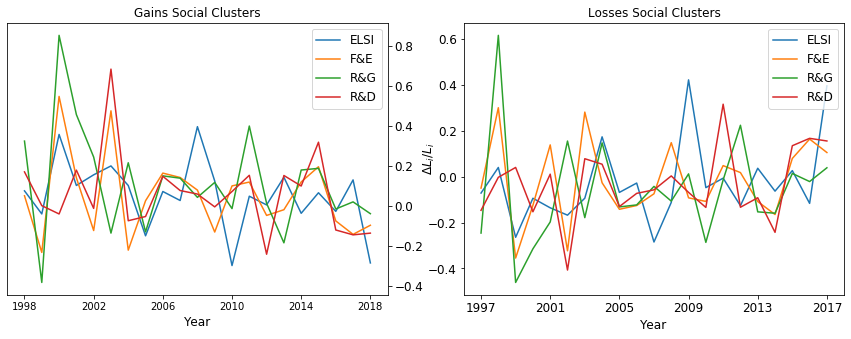

In [193]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(SocClustSeriesNorm['Year'].iloc[1:], RelGainsSoc)
plt.xlabel('Year', fontsize=12)
plt.ylabel(r'$\Delta L_i/L_i$', fontsize=12, labelpad=-430)
# plt.set_label_position("right")
# plt.yaxis.tick_right()
plt.legend(SocClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12, axis='y', which='major', labelleft=False, labelright=True, 
                left=False, right=True)
plt.xticks(ticks=[1998, 2002, 2006, 2010, 2014, 2018], labels=[1998, 2002, 2006, 2010, 2014, 2018])
plt.title('Gains Social Clusters', fontsize=12)

plt.subplot(122)
plt.plot(PhysClustSeriesNorm['Year'].iloc[:-1], RelLossesSoc)
plt.xlabel('Year', fontsize=12)
plt.legend(SocClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.xticks(ticks=[1997, 2001, 2005, 2009, 2013, 2017], labels=[1997, 2001, 2005, 2009, 2013, 2017])
plt.title('Losses Social Clusters', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Soc_clust_gains_losses.png', dpi=150)

Back to the absolute time series

Text(0.5, 1.0, 'Logarithmic')

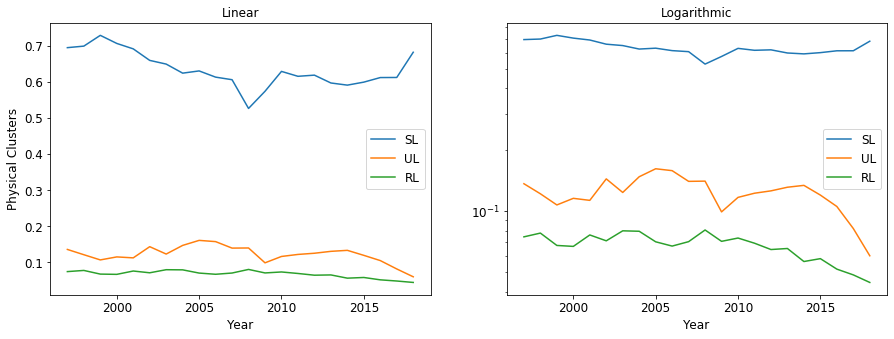

In [176]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(PhysClustSeriesNorm['Year'], PhysClustSeriesNorm[PhysClustSeriesNorm.columns[:-1]])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Physical Clusters', fontsize=12)
plt.legend(PhysClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Linear', fontsize=12)

plt.subplot(122)
plt.plot(PhysClustSeriesNorm['Year'], PhysClustSeriesNorm[PhysClustSeriesNorm.columns[:-1]])
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
plt.legend(PhysClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Logarithmic', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Phys_clust_trends.png', dpi=150)

Text(0.5, 1.0, 'Logarithmic')

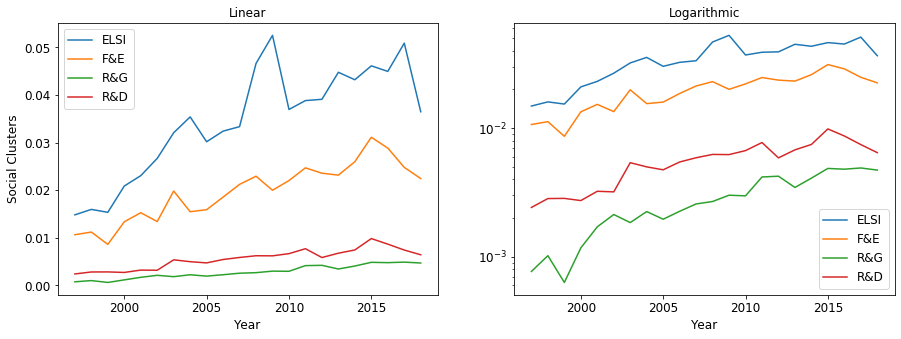

In [177]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(SocClustSeriesNorm['Year'], SocClustSeriesNorm[SocClustSeriesNorm.columns[:-1]])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Social Clusters', fontsize=12)
plt.legend(SocClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Linear', fontsize=12)

plt.subplot(122)
plt.plot(SocClustSeriesNorm['Year'], SocClustSeriesNorm[SocClustSeriesNorm.columns[:-1]])
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
plt.legend(SocClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Logarithmic', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Soc_clust_trends.png', dpi=150)

Text(0.5, 1.0, 'Social')

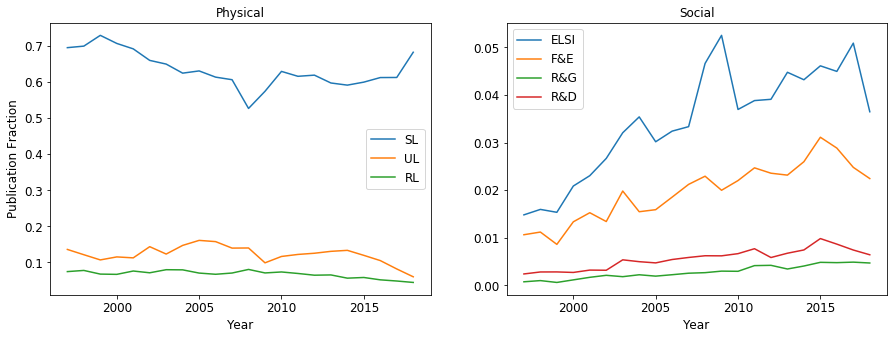

In [178]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(PhysClustSeriesNorm['Year'], PhysClustSeriesNorm[PhysClustSeriesNorm.columns[:-1]])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Publication Fraction', fontsize=12)
plt.legend(PhysClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Physical', fontsize=12)

plt.subplot(122)
plt.plot(SocClustSeriesNorm['Year'], SocClustSeriesNorm[SocClustSeriesNorm.columns[:-1]])
plt.xlabel('Year', fontsize=12)
# plt.ylabel('Social Clusters', fontsize=12)
plt.legend(SocClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Social', fontsize=12)

# plt.savefig('./../Manuscripts/Images/PhysSoc_clust_trends.png', dpi=150)

### Time-series of the clusters for the overlapping portion

In [179]:
Years = []
for i in range(1997,2019):
    ClustYear = []
    for j in KeysToClust:
        temp = 0
        for k in KeysToClust[j]:
            temp += ScopusAIIntersection[(ScopusAIIntersection['Keyword'] == k) & (ScopusAIIntersection['sort_year'] == i)]['Keyword'].count()
        ClustYear.append(temp)
    Years.append(ClustYear)
    
ClustSeries = pd.DataFrame(Years,columns=KeysToClust.keys())

TotMESeries = ScopusAI.groupby('sort_year').count().reset_index()['EID']

ClustSeriesNorm = ClustSeries.T/TotMESeries
ClustSeriesNorm = ClustSeriesNorm.T
ClustSeriesNorm['Year'] = range(1997,2019)

Text(0.5, 1.0, 'Logarithmic')

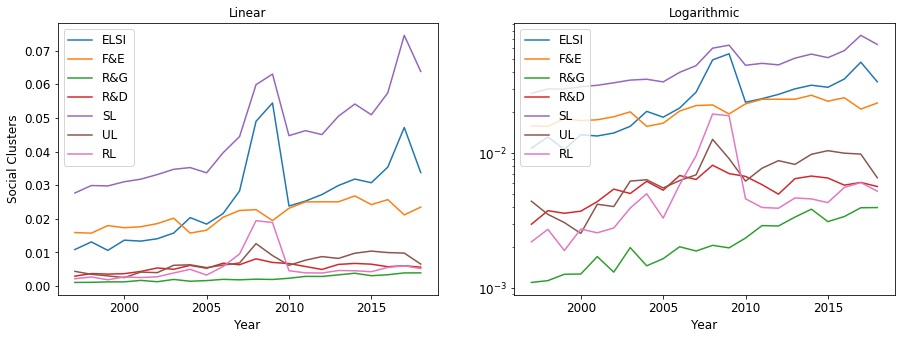

In [180]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(ClustSeriesNorm['Year'], ClustSeriesNorm[ClustSeriesNorm.columns[:-1]])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Social Clusters', fontsize=12)
plt.legend(ClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Linear', fontsize=12)

plt.subplot(122)
plt.plot(ClustSeriesNorm['Year'], ClustSeriesNorm[ClustSeriesNorm.columns[:-1]])
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
plt.legend(ClustSeriesNorm.columns[:-1], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Logarithmic', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Clust_trends_intersection.png', dpi=150)

Text(0.5, 1.0, 'Cumulative Logarithmic')

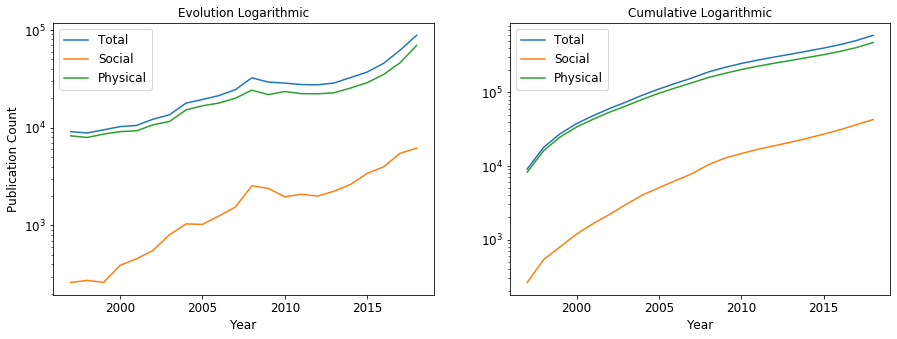

In [181]:
# Publication count time-series per domain and their respective cumulatives
plt.figure(figsize=(15,5))

Tots = PhysClustSeries.sum(axis=1)+SocClustSeries.sum(axis=1)+ClustSeries.sum(axis=1)
Socs = SocClustSeries.sum(axis=1)
Physs = PhysClustSeries.sum(axis=1)

# plt.subplot(221)
# plt.plot(range(1997,2019), Tots, range(1997,2019), Socs, range(1997,2019), Physs)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel('Publication Count', fontsize=12)
# plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
# plt.tick_params(labelsize=12)
# plt.title('Evolution Linear', fontsize=12)

# plt.subplot(222)
# plt.plot(range(1997,2019), np.cumsum(Tots), range(1997,2019), np.cumsum(Socs), range(1997,2019), np.cumsum(Physs))
# plt.xlabel('Year', fontsize=12)
# # plt.ylabel('Publication Count', fontsize=12)
# plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
# plt.tick_params(labelsize=12)
# plt.title('Cumulative Linear', fontsize=12)

plt.subplot(121)
plt.plot(range(1997,2019), Tots, range(1997,2019), Socs, range(1997,2019), Physs)
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Publication Count', fontsize=12)
plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Evolution Logarithmic', fontsize=12)


plt.subplot(122)
plt.plot(range(1997,2019), np.cumsum(Tots), range(1997,2019), np.cumsum(Socs), range(1997,2019), np.cumsum(Physs))
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
# plt.ylabel('Publication Count', fontsize=12)
plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Cumulative Logarithmic', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Domain_trends.png', dpi=150)

(200, 100000)

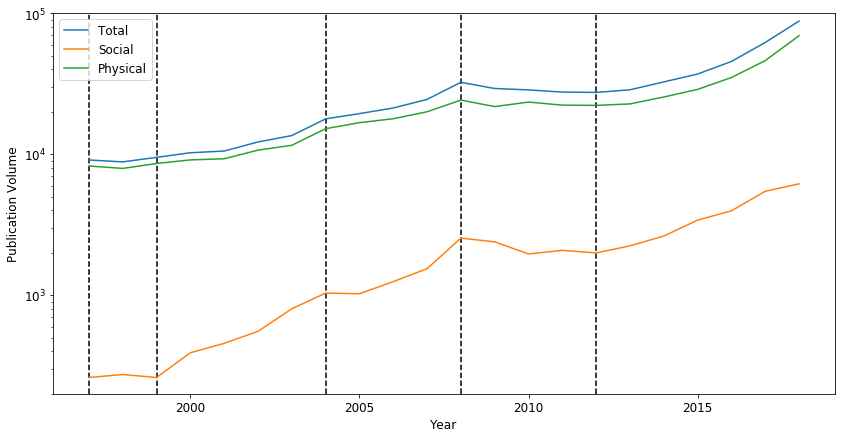

In [182]:
plt.figure(figsize=(14,7))#, frameon=False, dpi=100)
plt.plot(range(1997,2019), Tots, range(1997,2019), Socs, range(1997,2019), Physs)
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Publication Volume', fontsize=12)
plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
plt.tick_params(labelsize=12)
plt.vlines([1997,1999,2004,2008,2012], ymin=200, ymax=100000, linestyles='dashed')
# plt.text(1, -0.6, r'$\sum_{i=0}^\infty x_i$')
plt.ylim([200,100000])
# plt.title('', fontsize=12)
# plt.savefig('./../Manuscripts/Images/Primitive_event_horizon', dpi=150)

Text(0.5, 1.0, 'Evolution Logarithmic')

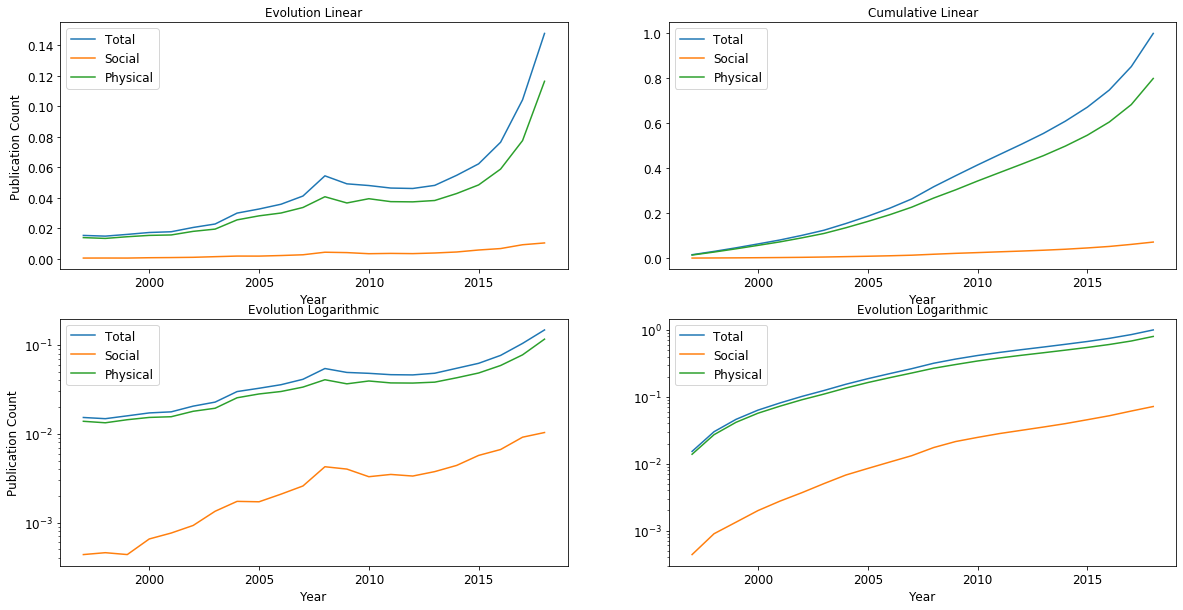

In [183]:
# Publication count time-series per domain and their respective cumulatives normalized to the total counts
plt.figure(figsize=(20,10))

Tots = PhysClustSeries.sum(axis=1)+SocClustSeries.sum(axis=1)+ClustSeries.sum(axis=1)
Socs = SocClustSeries.sum(axis=1)
Physs = PhysClustSeries.sum(axis=1)

plt.subplot(221)
plt.plot(range(1997,2019), Tots/Tots.sum(), range(1997,2019), Socs/Tots.sum(), range(1997,2019), Physs/Tots.sum())
plt.xlabel('Year', fontsize=12)
plt.ylabel('Publication Count', fontsize=12)
plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Evolution Linear', fontsize=12)

plt.subplot(222)
plt.plot(range(1997,2019), np.cumsum(Tots/Tots.sum()), range(1997,2019), np.cumsum(Socs/Tots.sum()), range(1997,2019), np.cumsum(Physs/Tots.sum()))
plt.xlabel('Year', fontsize=12)
# plt.ylabel('Publication Count', fontsize=12)
plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Cumulative Linear', fontsize=12)

plt.subplot(223)
plt.plot(range(1997,2019), Tots/Tots.sum(), range(1997,2019), Socs/Tots.sum(), range(1997,2019), Physs/Tots.sum())
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Publication Count', fontsize=12)
plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Evolution Logarithmic', fontsize=12)


plt.subplot(224)
plt.plot(range(1997,2019), np.cumsum(Tots/Tots.sum()), range(1997,2019), np.cumsum(Socs/Tots.sum()), range(1997,2019), np.cumsum(Physs/Tots.sum()))
plt.yscale('log')
plt.xlabel('Year', fontsize=12)
# plt.ylabel('Publication Count', fontsize=12)
plt.legend(['Total', 'Social', 'Physical'], fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Evolution Logarithmic', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Domain_trends_normal.png', dpi=150)

Another interlude of gains and losses for the overall domains

In [192]:
temp = Tots
Gden = Tots.values[:-1]
ttemp = Tots.diff().iloc[1:]
RelGainsTots = ttemp/Gden

Lden = temp.values[1:]
ttemp = temp.diff(-1).iloc[:-1]
RelLossesTots = ttemp/Lden

temp = Physs
Gden = Physs.values[:-1]
ttemp = Physs.diff().iloc[1:]
RelGainsPhyss = ttemp/Gden

Lden = temp.values[1:]
ttemp = temp.diff(-1).iloc[:-1]
RelLossesPhyss = ttemp/Lden

temp = Socs
Gden = Socs.values[:-1]
ttemp = Socs.diff().iloc[1:]
RelGainsSocs = ttemp/Gden

Lden = temp.values[1:]
ttemp = temp.diff(-1).iloc[:-1]
RelLossesSocs = ttemp/Lden

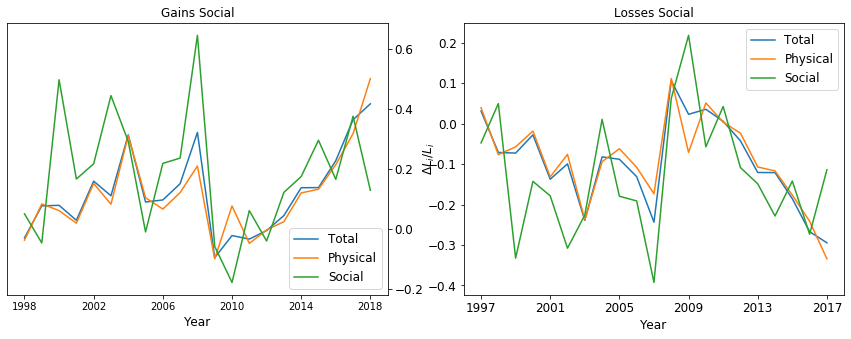

In [199]:
plt.figure(figsize=(15,5))

xg = SocClustSeriesNorm['Year'].iloc[1:]

plt.subplot(121)
plt.plot(xg, RelGainsTots, xg, RelGainsPhyss, xg, RelGainsSocs)
plt.xlabel('Year', fontsize=12)
plt.ylabel(r'$\Delta L_i/L_i$', fontsize=12, labelpad=-430)
# plt.set_label_position("right")
# plt.yaxis.tick_right()
plt.legend(['Total', 'Physical', 'Social'], fontsize=12)
plt.tick_params(labelsize=12, axis='y', which='major', labelleft=False, labelright=True, 
                left=False, right=True)
plt.xticks(ticks=[1998, 2002, 2006, 2010, 2014, 2018], labels=[1998, 2002, 2006, 2010, 2014, 2018])
plt.title('Gains Social', fontsize=12)

xl = PhysClustSeriesNorm['Year'].iloc[:-1]

plt.subplot(122)
plt.plot(xl, RelLossesTots, xl, RelLossesPhyss, xl, RelLossesSocs)
plt.xlabel('Year', fontsize=12)
plt.legend(['Total', 'Physical', 'Social'], fontsize=12)
plt.tick_params(labelsize=12)
plt.xticks(ticks=[1997, 2001, 2005, 2009, 2013, 2017], labels=[1997, 2001, 2005, 2009, 2013, 2017])
plt.title('Losses Social', fontsize=12)

# plt.savefig('./../Manuscripts/Images/AI_domains_gains_losses.png', dpi=150)

In [184]:
# Test of normalization. The test dataframe should add up to unity.
test = ClustSeriesNorm[ClustSeriesNorm.columns[:-1]] + pd.concat([SocClustSeriesNorm[SocClustSeriesNorm.columns[:-1]], PhysClustSeriesNorm[PhysClustSeriesNorm.columns[:-1]]], axis=1)

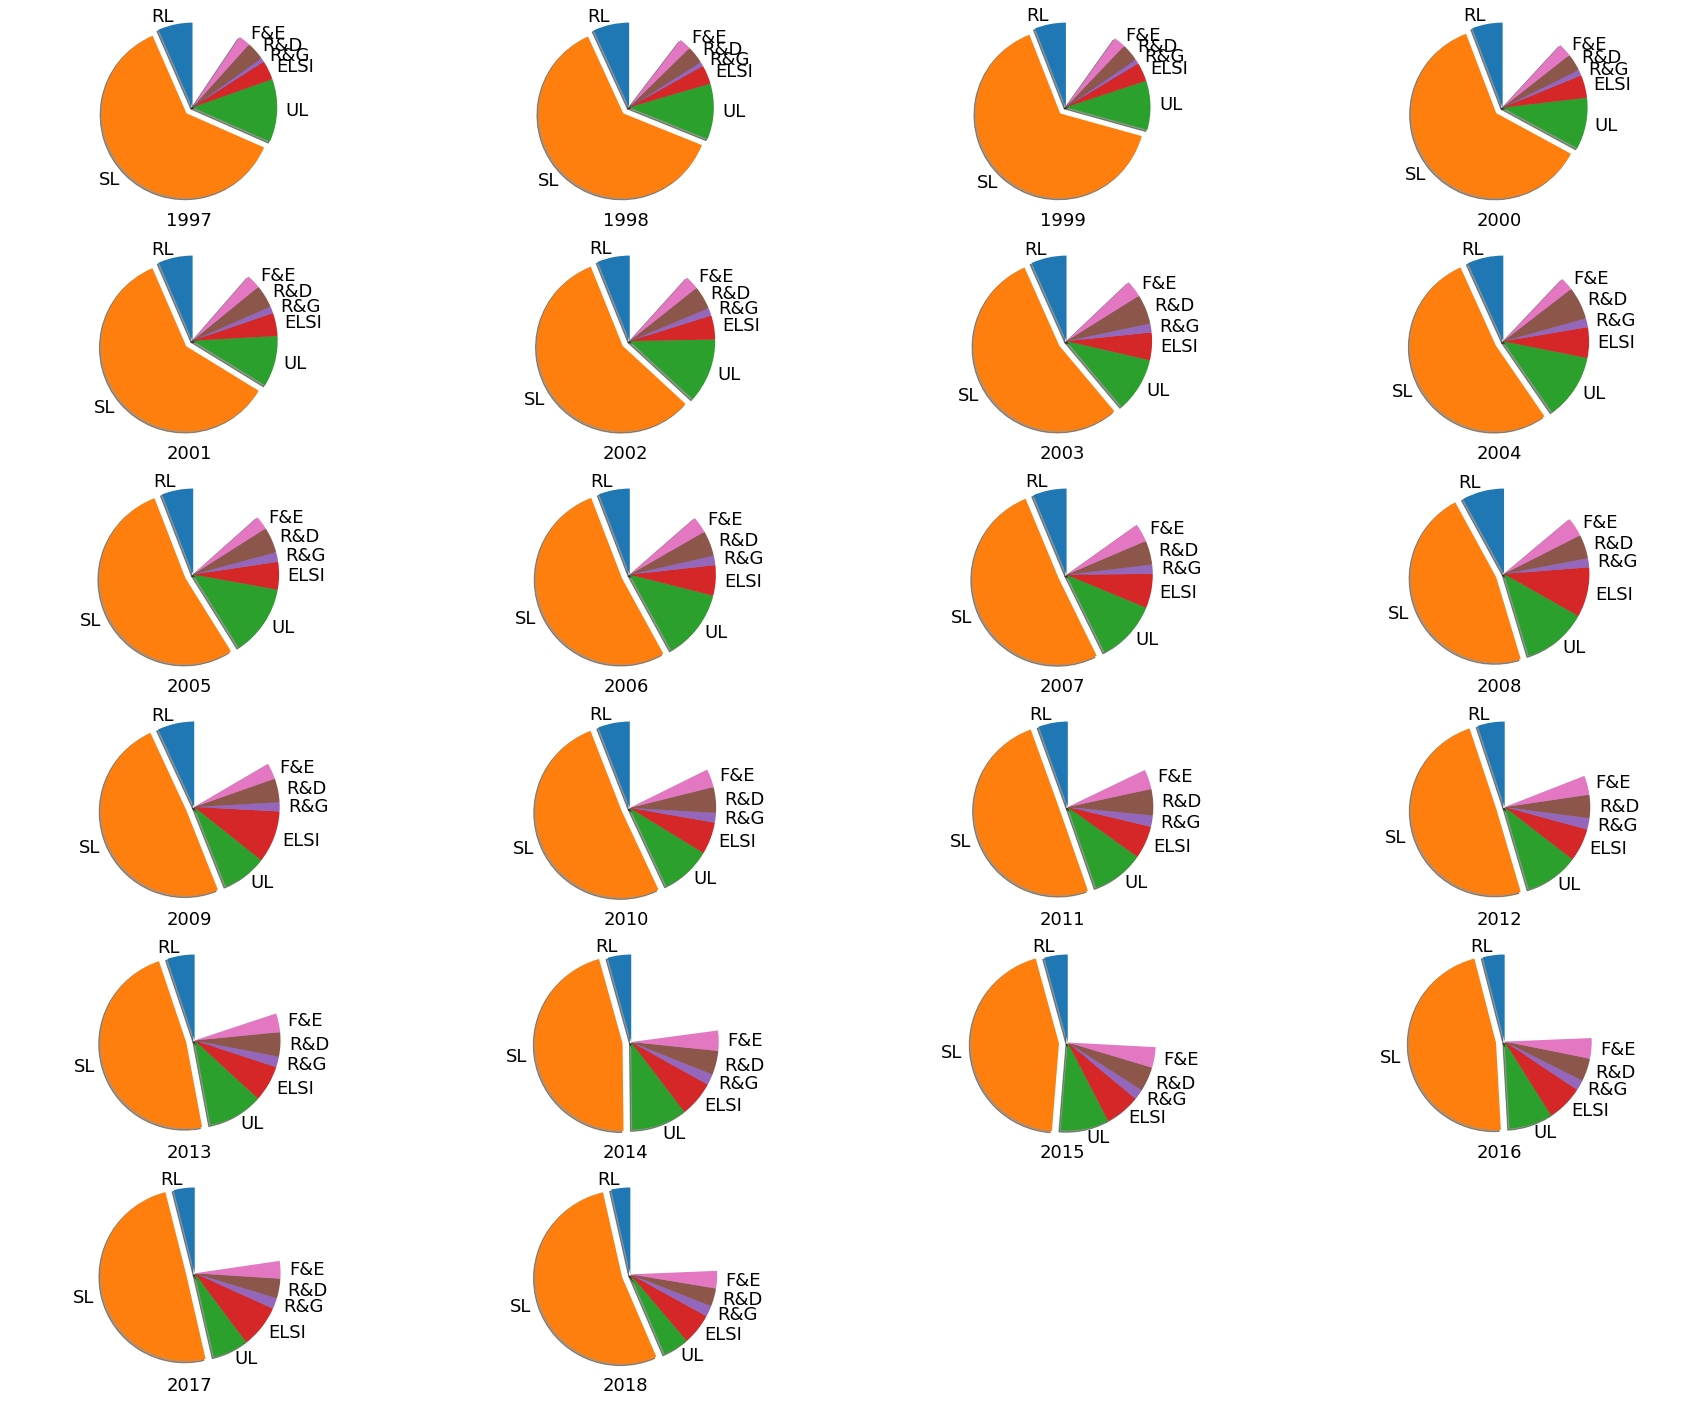

In [29]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.figure(figsize=(30,25))
for i,j in zip(range(22),time):        
    
    labels = 'RL', 'SL', 'UL', 'ELSI', 'R&G', 'R&D', 'F&E'
    sizes = [SumRLAll[i], SumSLAll[i], SumULAll[i], SumELSIAll[i], SumRegGovAll[i], SumRDACAll[i], SumFinEconAll[i]]
    explode = (0, 0.1, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    plt.subplot(6,4,i+1)
    plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=90, textprops={'fontsize': 18})
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.xlabel(j,fontsize=18)
    
# plt.savefig('./../Manuscripts/Images/Cluster_trends_pies.png', dpi=150)

### Descriptive Results by Year

In [127]:
Data_phys_key.describe()

,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,720.312500,747.78125,767.968750,915.031250,961.750000,1165.281250,1461.968750,1787.53125,1976.062500,2110.125000,...,3080.718750,3185.125000,3245.937500,3286.656250,3648.156250,4032.843750,4656.187500,5560.625000,7421.593750,0.062500
std,1583.650956,1603.10394,1708.341933,1833.767539,1956.569579,2255.162911,2889.015665,3365.27632,3483.399053,3615.764799,...,4247.101685,4430.869883,4411.827205,4414.184217,4868.115434,5202.984473,6118.749374,7458.475779,10570.894334,0.245935
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,4.750000,6.00000,14.500000,17.000000,14.500000,14.250000,24.000000,36.00000,52.500000,55.750000,...,87.750000,78.500000,85.500000,104.000000,127.500000,165.000000,148.500000,206.000000,924.250000,0.000000
50%,129.000000,160.00000,172.500000,224.000000,284.500000,380.000000,489.000000,570.00000,755.000000,854.500000,...,1462.000000,1650.500000,1769.500000,1856.500000,2056.000000,2275.500000,2722.500000,3198.000000,3592.000000,0.000000
75%,576.000000,642.25000,562.500000,629.500000,728.250000,1181.500000,1573.750000,1687.25000,2026.000000,2377.250000,...,3883.750000,4042.750000,3860.000000,4052.500000,4392.500000,4538.000000,4860.500000,6581.750000,9388.000000,0.000000
max,7605.000000,7332.00000,8273.000000,8140.000000,8620.000000,9161.000000,12949.000000,14370.00000,14089.000000,14673.000000,...,19079.000000,18564.000000,17820.000000,17966.000000,18418.000000,18963.000000,23423.000000,30613.000000,45513.000000,1.000000


In [137]:
Data_soc_key.describe()

,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.00000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0
mean,511.285714,603.357143,667.285714,754.571429,817.857143,1011.285714,1238.785714,1487.857143,1666.785714,1800.571429,...,2769.642857,2969.571429,3235.00000,3494.571429,3890.142857,4115.142857,4550.357143,5054.428571,5731.928571,0.0
std,1386.560627,1532.260603,1661.862969,1838.273342,2020.217538,2460.795069,2989.454753,3690.877024,3976.312946,4273.952984,...,5882.303547,6112.994063,6690.77551,7108.143452,7723.841321,8220.255029,8998.453471,9793.079540,10862.092881,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.00000,4.000000,3.000000,2.000000,8.000000,3.000000,14.000000,0.0
25%,0.000000,0.000000,0.250000,0.000000,0.000000,2.000000,2.000000,1.250000,1.750000,2.250000,...,16.750000,19.500000,19.25000,41.000000,45.500000,38.000000,59.750000,56.500000,89.500000,0.0
50%,0.000000,1.500000,2.500000,4.500000,3.000000,6.500000,10.000000,6.500000,10.500000,10.000000,...,77.000000,133.500000,191.50000,355.500000,546.500000,840.500000,1049.000000,1215.500000,1434.500000,0.0
75%,192.000000,287.000000,340.750000,418.500000,469.750000,596.000000,702.750000,800.750000,1047.250000,1242.250000,...,2736.750000,3546.000000,4267.50000,4796.250000,5510.000000,5427.750000,5639.750000,5831.000000,6251.000000,0.0
max,5165.000000,5597.000000,6021.000000,6760.000000,7494.000000,9080.000000,11044.000000,13737.000000,14740.000000,15829.000000,...,21831.000000,22871.000000,25219.00000,26811.000000,29080.000000,31139.000000,34154.000000,37325.000000,41351.000000,0.0


### Descriptive Results by Keyword

In [128]:
Data_phys_key_T.describe()

,"""\""'\""\""Computer Vision\""\""'\""""","""\""'\""\""data analy*\""\""'\""""","""\""'\""\""Deep learning\""\""'\""""","""\""'\""\""Fuzzy systems\""\""'\""""","""\""'\""\""generative adversarial networks\""\""'\""""","""\""'\""\""geographic information system\""\""'\""""","""\""'\""\""human-machine*\""\""'\""""","""\""'\""\""masint\""\""'\""""","""\""'\""\""measurement and signature intelligence\""\""'\""""","""\""'\""\""natural language processing\""\""'\""""",...,bioinformatics,Convolutional* neural networks,data graph analy*,fault detection,fault tolerance,geospatial intelligence,imagery intelligence,machine learning,recommender systems,remote sensing
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0000,...,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,4569.304348,12707.869565,1297.739130,2043.739130,60.956522,2824.043478,609.304348,1.304348,1.086957,1935.0000,...,4826.869565,1023.956522,1755.217391,2734.260870,1464.260870,40.086957,88.869565,6943.565217,828.565217,8165.260870
std,2775.098318,6686.602537,3608.470341,1576.445634,245.163485,1401.789975,423.107813,1.145536,1.276111,1448.8977,...,3861.097292,2917.542575,1257.491405,1914.309518,809.700574,30.151003,58.766336,8124.260944,902.473461,4231.261935
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2189.500000,7822.000000,17.500000,537.500000,0.000000,1444.500000,233.000000,0.500000,0.000000,606.0000,...,994.500000,12.000000,595.000000,1087.500000,706.000000,5.000000,27.000000,1151.000000,70.000000,4730.500000
50%,3857.000000,13265.000000,70.000000,2202.000000,0.000000,3404.000000,586.000000,1.000000,1.000000,2017.0000,...,4660.000000,29.000000,1530.000000,2715.000000,1610.000000,43.000000,95.000000,4591.000000,443.000000,7191.000000
75%,6187.000000,14894.000000,269.500000,3518.500000,0.000000,4025.000000,898.000000,2.000000,2.000000,2692.5000,...,7850.500000,75.000000,2628.500000,3793.500000,1905.500000,70.500000,123.500000,8454.000000,1492.500000,11866.000000
max,10885.000000,28065.000000,16050.000000,4323.000000,1166.000000,4340.000000,1572.000000,4.000000,4.000000,5483.0000,...,11818.000000,12825.000000,4242.000000,6729.000000,2976.000000,81.000000,199.000000,33745.000000,2833.000000,15629.000000


In [129]:
Data_soc_key_T.describe()

,"""\""'\""\""remote education\""\""'\""""","""\""'\""\""risk governance\""\""'\""""","""\""'\""\""risk management\""\""'\""""","""\""'\""\""smart cities\""\""'\""""","""\""'\""\""smart econ*\""\""'\""""","""\""'\""\""smart education\""\""' \""""","""\""'\""\""smart grids\""\""'\""""","""\""'\""\""smart health*\""\""'\""""","""\""'\""\""smart supply chain\""\""' \""""","""\""'\""\""social implications\""\""'\""""","""\""'\""\""supply chain\""\""'\""""",cybersafety OR cybersecurity,decision analysis,resilience
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,15.478261,39.304348,4346.043478,607.608696,4.652174,9.347826,1277.478261,40.826087,2.086957,488.086957,3678.913043,204.478261,18367.391304,3244.086957
std,11.602780,45.243216,1967.853826,1349.068694,7.438284,18.401108,1686.313782,77.193766,3.274045,550.135431,2555.888440,354.296341,11349.229845,3280.136831
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,3.500000,2602.000000,1.500000,0.000000,0.000000,0.000000,2.500000,0.000000,76.500000,1220.500000,6.000000,8287.000000,685.000000
50%,14.000000,18.000000,4459.000000,4.000000,1.000000,0.000000,24.000000,7.000000,1.000000,150.000000,3877.000000,33.000000,17225.000000,1828.000000
75%,23.000000,70.500000,6165.000000,351.500000,5.500000,10.500000,3225.000000,38.000000,3.000000,844.500000,5701.500000,195.500000,26015.000000,4965.000000
max,40.000000,139.000000,6640.000000,5084.000000,24.000000,73.000000,4444.000000,317.000000,14.000000,1510.000000,8115.000000,1359.000000,41351.000000,11139.000000


## PCA and k-means clustering experimentation

In [17]:
KwdsYears.head()

,Keyword,sort_year,EID,StringEID
0,Robot*,1997,676,676
1,Robot*,1998,685,685
2,Robot*,1999,639,639
3,Robot*,2000,683,683
4,Robot*,2001,803,803


In [18]:
x = KwdsYears.iloc[:, [1,2]].values

In [27]:
Allkmeans = KMeans(n_clusters=7)
y_kmeans = Allkmeans.fit_predict(x)
# print(y_kmeans)

# kmeans.cluster_centers_

Text(0, 0.5, 'Error')

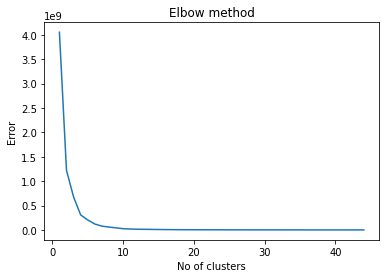

In [28]:
# TODO: Investigate the silhouette method
Error =[]
for i in range(1, 45):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 45), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')

### K-means for 7 clusters (verifying the empirical categorisation)

Text(0, 0.5, 'Publication Number')

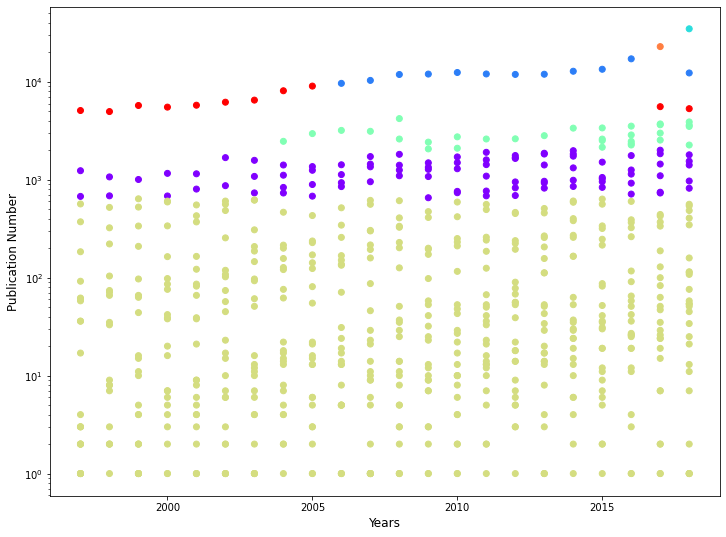

In [49]:
plt.figure(figsize=(12,9))
plt.scatter(x[:,0], x[:,1], c=y_kmeans, cmap='rainbow')
plt.yscale('log')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Publication Number', fontsize=12)
plt.tick_params(la)

### Combining k-means clustering with PCA (obsolete: revise)

In [90]:
clusters = 3
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(Data_phys_key)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [91]:
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips]

In [92]:
pca = PCA(3) 
pca.fit(Data_phys_key) 
  
pca_data = pd.DataFrame(pca.transform(Data_phys_key))

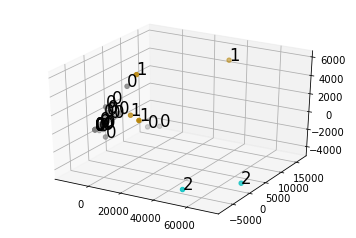

In [93]:
fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

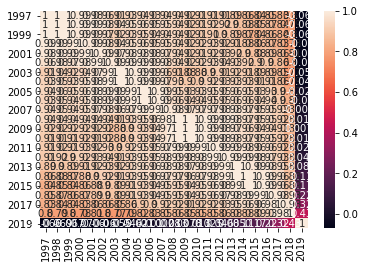

In [73]:
sns.heatmap(Data_phys_key.corr(), annot = True) 